In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("Data/New_NFLX.csv")

In [3]:
df.columns=df.columns.str.lower()

In [4]:
df=df[["date","close"]]

In [5]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('2022-09-19')
datetime_object

datetime.datetime(2022, 9, 19, 0, 0)

In [6]:
df["date"]=df["date"].apply(str_to_datetime)

In [7]:
df

,date,close
0,2022-09-19,243.630005
1,2022-09-20,242.850006
2,2022-09-21,236.869995
3,2022-09-22,237.050003
4,2022-09-23,226.410004
...,...,...
247,2023-09-13,412.239990
248,2023-09-14,400.489990
249,2023-09-15,396.940002
250,2023-09-18,394.399994


In [8]:
df.index=df.pop("date")

<Axes: xlabel='date'>

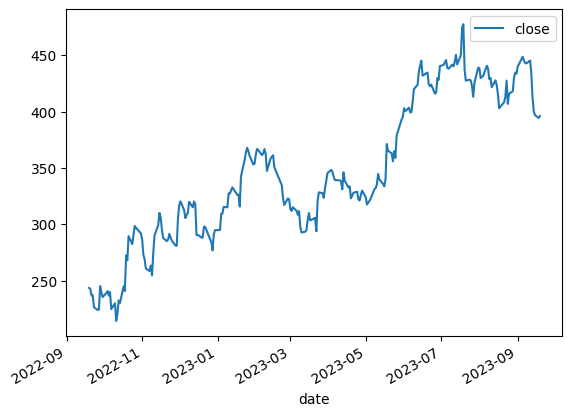

In [9]:
df.plot()

In [10]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2022-12-31', 
                                '2023-09-18', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2022-12-31,284.170013,276.880005,291.119995,294.880005
1,2023-01-04,291.119995,294.880005,294.950012,309.410004
2,2023-01-05,294.880005,294.950012,309.410004,309.700012
3,2023-01-06,294.950012,309.410004,309.700012,315.549988
4,2023-01-09,309.410004,309.700012,315.549988,315.170013
...,...,...,...,...,...
173,2023-09-12,443.140015,442.799988,445.359985,434.690002
174,2023-09-13,442.799988,445.359985,434.690002,412.239990
175,2023-09-14,445.359985,434.690002,412.239990,400.489990
176,2023-09-15,434.690002,412.239990,400.489990,396.940002


In [11]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((178,), (178, 3, 1), (178,))

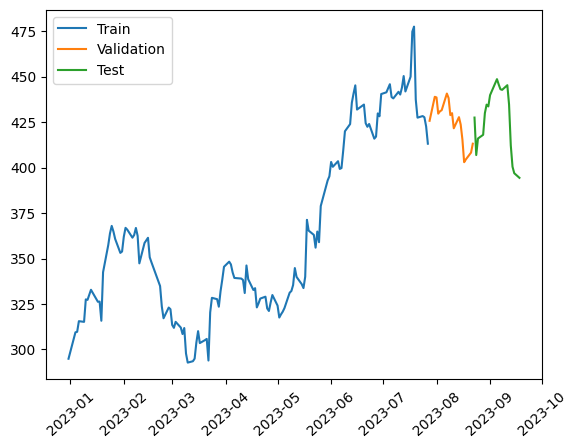

In [12]:

q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.xticks(rotation=42)
plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)



In [ ]:
train_predictions = model.predict(X_train).flatten()


In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])


In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(dates_train, train_predictions,"b-",linewidth=2)
plt.plot(dates_train, y_train,"r-",linewidth=2)
plt.plot(dates_test, test_predictions,"b--",linewidth=2)
plt.plot(dates_test, y_test,"r--",linewidth=2)
plt.plot(recursive_dates, recursive_predictions,"y",linewidth=2)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])
plt.grid()
plt.xticks(rotation=42)
plt.title("Stock Market",fontsize=14)
plt.xlabel("Date",fontsize=13)
plt.ylabel("Close values",fontsize=13)
plt.tight_layout()
plt.savefig("Stocks.png",dpi=300,bbox_inches="tight")